In [1]:
#standard libraries
import pandas as pd
import numpy as np
import re
import pickle
from unidecode import unidecode
import matplotlib.pyplot as plt

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

#nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter
from langdetect import detect

#preprocessing and feature extraction
import helper

#tensorflow
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import FeatureSpace

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import random
random.seed(42)

In [2]:
df = pd.read_csv('data/online_ship_listing_data.csv')

In [3]:
#df = helper.preprocess_df(df)

In [4]:
#df_test = df.copy()

In [5]:
#df_test = helper.create_features(df_test)

In [6]:
#splitting the dataframe
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1184 train examples
296 validation examples
370 test examples


In [7]:
train.shape

(1184, 16)

In [8]:
val.shape

(296, 16)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, 402 to 1772
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1184 non-null   int64  
 1   name           1184 non-null   object 
 2   price          1184 non-null   float64
 3   location       1184 non-null   object 
 4   offerer        1184 non-null   object 
 5   id             1184 non-null   int64  
 6   description    1184 non-null   object 
 7   year           1184 non-null   int64  
 8   manufacturer   1184 non-null   object 
 9   model          1180 non-null   object 
 10  category       1184 non-null   object 
 11  length         1184 non-null   float64
 12  fuel_type      1119 non-null   object 
 13  hull_material  1184 non-null   object 
 14  hull_shape     260 non-null    object 
 15  country        1184 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 157.2+ KB


In [10]:
def df_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    
    df = helper.preprocess_df(df)
    df, all_cols = helper.create_features(df)
    labels = df.pop('price')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds, all_cols

In [11]:
#convert dataframe to dataset
batch_size = 32
train_ds, all_cols = df_to_dataset(train)
val_ds, _ = df_to_dataset(val, shuffle=False, batch_size=batch_size)

C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['word_count'], axis=1, inplace=True)
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [12]:
#sanity checking
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of fuel tank:', feature_batch['fuel_type'])
    print('A batch of country:', feature_batch['country'])
    print('A batch of year:', feature_batch['year'])
    print('A batch of targets:', label_batch)

Every feature: ['year', 'model', 'category', 'length', 'fuel_type', 'hull_material', 'country', 'noun_counts', 'verb_counts', 'adjective_counts', 'bilge_pump', 'deck_finish', 'fuel_tank', 'level_indicator', 'material_grp', 'mehr_anzeigen', 'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit', 'avg_price_by_hull_material', 'avg_price_by_fuel_type', 'avg_price_by_category']
A batch of fuel tank: tf.Tensor(
[b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'petrol'
 b'diesel' b'diesel' b'diesel' b'diesel' b'petrol' b'other' b'diesel'
 b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel'
 b'petrol' b'diesel' b'diesel' b'diesel'], shape=(32,), dtype=string)
A batch of country: tf.Tensor(
[b'netherlands' b'afghanistan' b'afghanistan' b'germany' b'italy'
 b'grenada' b'afghanistan' b'spain' b'netherlands' b'spain' b'turkey'
 b'germany' b'italy' b'afghanistan' b'spain' b'italy' b'germ

In [13]:
fileName = 'model/column_names.pkl'
with open(fileName,'wb') as f:
    pickle.dump(all_cols,f)

In [14]:
float_normalized_cols = ['length', 'noun_counts', 'verb_counts', 'adjective_counts', 'avg_price_by_hull_material',
                        'avg_price_by_fuel_type', 'avg_price_by_category']
float_cols = ['bilge_pump', 'deck_finish', 'fuel_tank', 'level_indicator', 'material_grp', 'mehr_anzeigen',
             'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit']
string_categorical_cols = ['model', 'category', 'hull_material', 'country', 'fuel_type']
float_discretized_cols = ['year']

float_normalized = 'float_normalized'
just_float = 'float'
string_categorical = 'string_categorical'
float_discretized = 'float_discretized'

In [15]:
all_keys = sorted(float_normalized_cols + float_cols + string_categorical_cols)
features_dict = {key: float_normalized if key in float_normalized_cols else (just_float if key in float_cols else string_categorical) for key in all_keys}

In [16]:
features_dict['year'] = FeatureSpace.float_discretized(num_bins=10)

In [17]:
features_dict

{'adjective_counts': 'float_normalized',
 'avg_price_by_category': 'float_normalized',
 'avg_price_by_fuel_type': 'float_normalized',
 'avg_price_by_hull_material': 'float_normalized',
 'bilge_pump': 'float',
 'category': 'string_categorical',
 'country': 'string_categorical',
 'deck_finish': 'float',
 'fuel_tank': 'float',
 'fuel_type': 'string_categorical',
 'hull_material': 'string_categorical',
 'length': 'float_normalized',
 'level_indicator': 'float',
 'material_grp': 'float',
 'mehr_anzeigen': 'float',
 'model': 'string_categorical',
 'noun_counts': 'float_normalized',
 'sailing_yacht': 'float',
 'stainless_steel': 'float',
 'tank_litre': 'float',
 'teak_cockpit': 'float',
 'verb_counts': 'float_normalized',
 'year': <keras.src.utils.feature_space.Feature at 0x223cfe21890>}

In [18]:
feature_space = FeatureSpace(
    features={
    "adjective_counts": 'float_normalized',
    "avg_price_by_category": 'float_normalized',
    "avg_price_by_fuel_type": 'float_normalized',
    "avg_price_by_hull_material": 'float_normalized',
    "bilge_pump": 'float',
    "category": 'string_categorical',
    "country": 'string_categorical',
    "deck_finish": 'float',
    "fuel_tank": 'float',
    "fuel_type": 'string_categorical',
    "hull_material": 'string_categorical',
    "length": 'float_normalized',
    "level_indicator": 'float',
    "material_grp": 'float',
    "mehr_anzeigen": 'float',
    "model": 'string_categorical',
    "noun_counts": 'float_normalized',
    "sailing_yacht": 'float',
    "stainless_steel": 'float',
    "tank_litre": 'float',
    "teak_cockpit": 'float',
    "verb_counts": 'float_normalized',
    "year": FeatureSpace.float_discretized(num_bins=10)
    },
    output_mode="concat",
    crosses=[
        FeatureSpace.cross(feature_names=("model", "category"), crossing_dim=64),
        FeatureSpace.cross(feature_names=("hull_material", "category"), crossing_dim=16),
        FeatureSpace.cross(feature_names=("fuel_type", "category"), crossing_dim=16),
        
    ],
)

#needs to adapt the feature_space. Reminder: feature_space needs to be adapted to a dataset WITHOUT LABEL
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [36]:
feature_space.save('model/feature_space.keras')

In [19]:
#checking the dataset shape
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 964)
preprocessed_x.dtype: <dtype: 'float32'>


In [20]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [21]:
#remapping to label
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

#To make sure the training data is read infinitely
preprocessed_train_ds = preprocessed_train_ds.repeat()

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [22]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()
x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x) #using dropout layer to avoid overfitting
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="linear")(x)

#1st model: training_model
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="mse", metrics=[rmse, "mse"]
)

#2nd model: inference_model
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [23]:
TRAIN_BATCH_SIZE = 32 
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 500
NUM_EVAL_EXAMPLES = 14906

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
#early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [24]:
#training the model
history = training_model.fit(preprocessed_train_ds,
                    validation_data=preprocessed_val_ds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping]
                    )

Epoch 1/500
18/18 [==============================] - 2s 28ms/step - loss: 55007002624.0000 - rmse: 232788.0938 - mse: 55007002624.0000 - val_loss: 51591831552.0000 - val_rmse: 222506.6875 - val_mse: 51591831552.0000
Epoch 2/500
18/18 [==============================] - 0s 19ms/step - loss: 62922035200.0000 - rmse: 248751.6719 - mse: 62922035200.0000 - val_loss: 51493920768.0000 - val_rmse: 222292.9219 - val_mse: 51493920768.0000
Epoch 3/500
18/18 [==============================] - 0s 18ms/step - loss: 53347373056.0000 - rmse: 228950.0156 - mse: 53347373056.0000 - val_loss: 49694117888.0000 - val_rmse: 218326.8281 - val_mse: 49694117888.0000
Epoch 4/500
18/18 [==============================] - 0s 17ms/step - loss: 49945231360.0000 - rmse: 220705.3281 - mse: 49945231360.0000 - val_loss: 34680115200.0000 - val_rmse: 182181.2812 - val_mse: 34680115200.0000
Epoch 5/500
18/18 [==============================] - 0s 18ms/step - loss: 29813178368.0000 - rmse: 170674.9844 - mse: 29813178368.0000 -

18/18 [==============================] - 0s 17ms/step - loss: 4584249856.0000 - rmse: 65958.8594 - mse: 4584249856.0000 - val_loss: 3944370432.0000 - val_rmse: 61234.9453 - val_mse: 3944370432.0000
Epoch 40/500
18/18 [==============================] - 0s 17ms/step - loss: 5424148480.0000 - rmse: 72240.3438 - mse: 5424148480.0000 - val_loss: 3833562880.0000 - val_rmse: 60609.8789 - val_mse: 3833562880.0000
Epoch 41/500
18/18 [==============================] - 0s 16ms/step - loss: 4664179200.0000 - rmse: 66168.2812 - mse: 4664179200.0000 - val_loss: 4241362944.0000 - val_rmse: 63196.4219 - val_mse: 4241362944.0000
Epoch 42/500
18/18 [==============================] - 0s 17ms/step - loss: 4674291712.0000 - rmse: 66686.6719 - mse: 4674291712.0000 - val_loss: 4535481344.0000 - val_rmse: 65100.0195 - val_mse: 4535481344.0000
Epoch 43/500
18/18 [==============================] - 0s 17ms/step - loss: 6249242624.0000 - rmse: 75918.8516 - mse: 6249242624.0000 - val_loss: 3995696384.0000 - val_rm

In [25]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right');    

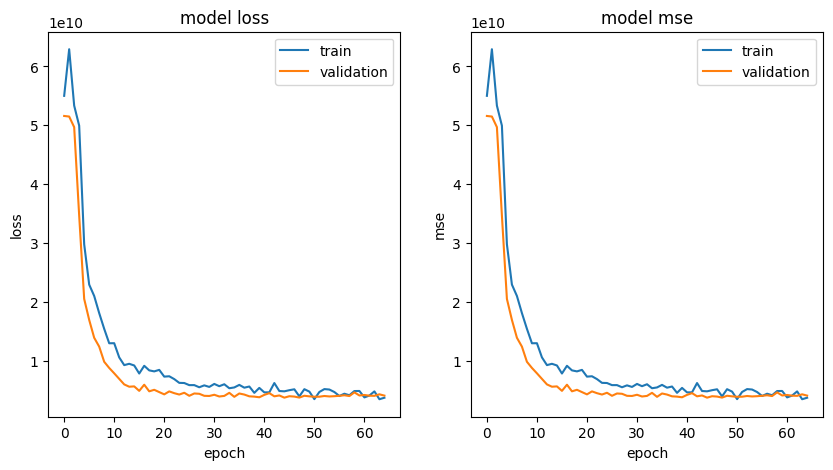

In [26]:
plot_curves(history, ['loss', 'mse'])

In [27]:
#creating a sample data
sample = {
    "year":tf.convert_to_tensor([2010.]),
    "model":tf.convert_to_tensor(['gulet']),
    "category":tf.convert_to_tensor(['schoner']),
    "length":tf.convert_to_tensor([83.]),
    "fuel_type":tf.convert_to_tensor(['diesel']),
    "hull_material":tf.convert_to_tensor(['steel']),
    "country":tf.convert_to_tensor(['turkey']),
    "noun_counts":tf.convert_to_tensor([20.]),
    "verb_counts":tf.convert_to_tensor([20.]),
    "adjective_counts":tf.convert_to_tensor([20.]),
    "bilge_pump":tf.convert_to_tensor([1.]),
    "deck_finish":tf.convert_to_tensor([0.]),
    "fuel_tank":tf.convert_to_tensor([1.]),
    "level_indicator":tf.convert_to_tensor([1.]),
    "material_grp":tf.convert_to_tensor([0.]),
    "mehr_anzeigen":tf.convert_to_tensor([0.]),
    "sailing_yacht":tf.convert_to_tensor([1.]),
    "stainless_steel":tf.convert_to_tensor([0.]),
    "tank_litre":tf.convert_to_tensor([1.]),
    "teak_cockpit":tf.convert_to_tensor([1.]),
    "avg_price_by_hull_material":tf.convert_to_tensor([173764.8396226415]),
    "avg_price_by_fuel_type":tf.convert_to_tensor([172121.64462209304]),
    "avg_price_by_category":tf.convert_to_tensor([476125.0]),
    
}

In [28]:
predictions = inference_model.predict(sample)
print(predictions[0][0])

1/1 [==============================] - 0s 357ms/step
3150903.2


In [29]:
from tensorflow.keras.models import save_model, load_model

In [30]:
inference_model.save("custom_model.keras")

In [34]:
reconstructed_model = load_model("custom_model.keras")

In [33]:
reconstructed_model.predict(sample)

1/1 [==============================] - 0s 303ms/step


array([[3024842.2]], dtype=float32)